# Simple 1-D example for HMRF-GMM


In [143]:
import numpy as np
import matplotlib.pyplot as plt

In [144]:
%matplotlib inline

## Set up synthetic model

We start with a simple model with only two possible outcomes and two feautres:

In [145]:
import scipy.stats as stats

In [188]:
np.random.seed(12345)
# define domain
x = np.arange(1000)
latent_1D = np.zeros_like(x)
dist = stats.bernoulli(0.01)
val = 0
for i in range(len(x)):
    if dist.rvs():
        val = 1 - val
    latent_1D[i] = val
        

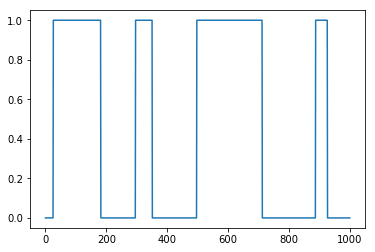

In [174]:
plt.plot(latent_1D)

## Feature classes

Now generate feature classes. Each class has one $\mu$ value and one covariance matrix for each latent variable:



In [175]:
# define statistics of class 1:
class ClassDensity(object):
    
    def __init__(self, mu, cov):
        self.mu = mu
        self.cov = cov
        
    def rvs(self):
        """Generate random values"""
        
        
        
        
        

Example from `toy_example.m`

```
mu=[6 9;4 12;9 14];
SIGMA(2,2,3)=0;
SIGMA(:,:,1)=3*[0.5625 0.225; 0.225 0.675];
SIGMA(:,:,2)=3*[1.125 0.225; 0.225 0.675];
SIGMA(:,:,3)=3*[0.5625 0.0225; 0.0225 0.675];

```

In [176]:
c1 = ClassDensity(np.array([6,9]),
                 np.array([[[0.5625, 0.225],[0.225, 0.675]],
                          [[0.5625, 0.225],[0.225, 0.675]]]))

c2 = ClassDensity(np.array([4,12]),
                 np.array([[[1.125, 0.225],[0.225, 0.675]],
                          [[1.125, 0.225],[0.225, 0.675]]]))

In [177]:
c1.cov, c1.mu

(array([[[ 0.5625,  0.225 ],
         [ 0.225 ,  0.675 ]],
 
        [[ 0.5625,  0.225 ],
         [ 0.225 ,  0.675 ]]]), array([6, 9]))

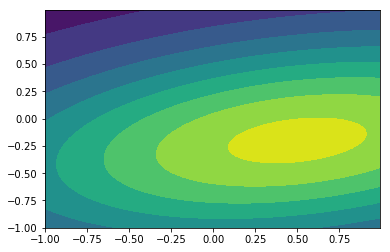

In [178]:
x1, y1 = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x1.shape + (2,))
pos[:, :, 0] = x1; pos[:, :, 1] = y1
rv = stats.multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
plt.contourf(x1, y1, rv.pdf(pos))


In [179]:
c1 = stats.multivariate_normal([6,9], [[0.5625, 0.225],[0.225, 0.675]])

In [180]:
c2 = stats.multivariate_normal([4,12], [[1.125, 0.225],[0.225, 0.675]])

c3 = stats.multivariate_normal([9,14], [[0.5625, 0.0225],[0.0225, 0.675]])

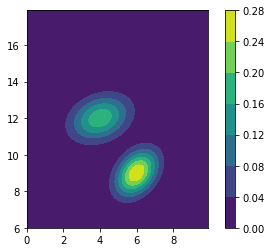

In [181]:
x1, y1 = np.mgrid[-0:10:.1, 6:18:.1]
pos = np.empty(x1.shape + (2,))
pos[:, :, 0] = x1; pos[:, :, 1] = y1
plt.contourf(x1, y1, c1.pdf(pos) + c2.pdf(pos)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()

## Generate samples according to latent field

In [182]:
# for 

observed_field = np.empty((len(x), 2))

for i,l in enumerate(latent_1D):
    # generate a 2-d random vector at each point
    if l == 0:
        observed_field[i,:] = c1.rvs()
    elif l == 1:
        observed_field[i,:] = c2.rvs()
    
    

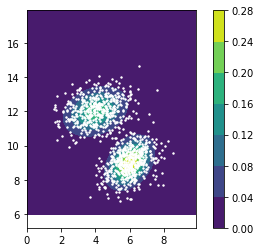

In [183]:
plt.contourf(x1, y1, c1.pdf(pos) + c2.pdf(pos)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()
plt.scatter(observed_field[:,0], observed_field[:,1], c='w', s=2)


## Construct cell structure

We now need to define the neighborhood system

In [200]:
class Element(object):
    
    def __init__(self, pos, center):
        """Define Element structure"""
        self.pos = pos
        self.center = center
        # self.neighbors = neighbors
        # self.color = color
        # self.label = np.random.randint(1)
        # self.energy = energy
        # self.entropy = entropy
        # self.prob = prob
        self.neighbors = []
        # self.beta # correlation strength
        
        
        
    
        
        

In [192]:
import scipy.spatial.distance as d

In [225]:
# iterate through our grid/ domain and set up element structure
all_elements = []

for i,xx in enumerate(x):
    # create element
    tmp_element = Element(i, xx)
    all_elements.append(tmp_element)
    
# now: add neighbors
for i,xx in enumerate(x):
    if i == 0:
        all_elements[i].neighbors.append(all_elements[1])
    elif i == len(x)-1:
        all_elements[i].neighbors.append(all_elements[-1])
    else:
        all_elements[i].neighbors.append(all_elements[i-1])
        all_elements[i].neighbors.append(all_elements[i+1])
        
    # update number of degree
    all_elements[i].degree = len(all_elements[i].neighbors)

<div class="alert alert-warning">*To Do Florian*: define general methods to find neighbors based on distances</div>

## Determine element color

Used for later parallelisation (here: simply changing)

In [223]:
for i,e in enumerate(all_elements):
    if np.mod(i,2) == 0:
        e.color = 0
    else:
        e.color = 1

### Assign obervation value to elements



# First round: initialise with gmm

Aim: find initial labels for all elements using gmm

In [226]:
# fit a Gaussian Mixture Model with two components
from sklearn import mixture
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')

In [ ]:
# additional step: scale data?
# from sklearn import preprocessing
# 
# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)

In [227]:
# here: simply assign data array
scaled_data2 = observed_field

In [228]:
clf.fit(scaled_data2)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

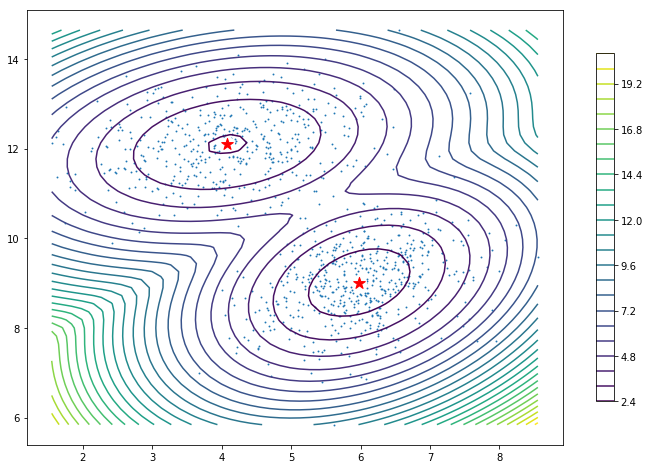

In [230]:
# display predicted scores by the model as a contour plot
from matplotlib.colors import LogNorm
plt.figure(figsize=(12,8))

x = np.linspace(np.min(scaled_data2[:,0]), np.max(scaled_data2[:,0]))
y = np.linspace(np.min(scaled_data2[:,1]), np.max(scaled_data2[:,1]))
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

# CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
#                   levels=np.logspace(0, 3, 20))
CS = plt.contour(X,Y,Z,30)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(scaled_data2[:, 0], scaled_data2[:, 1], .8)
# plot means
for cx,cy in clf.means_:
    plt.scatter(cx, cy, marker='o', s=200, c='w')
    plt.scatter(cx, cy, marker='*', s=150, c='r')

In [236]:
print(clf.means_)
print(clf.covariances_)

[[  4.07865176  12.09400085]
 [  5.98067397   9.01298327]]
[[[ 1.08816905  0.19824496]
  [ 0.19824496  0.60439024]]

 [[ 0.62805456  0.2166607 ]
  [ 0.2166607   0.66879647]]]


In [238]:
c1.mean, c2.mean

(array([ 6.,  9.]), array([  4.,  12.]))

In [239]:
c1.cov, c2.cov

(array([[ 0.5625,  0.225 ],
        [ 0.225 ,  0.675 ]]), array([[ 1.125,  0.225],
        [ 0.225,  0.675]]))

So, obviously, the fit is really good in this case - as the problem is easy to separate in feature space...

### Assign labels to elements according gmm fit


In [ ]:
for i,e in enumerate(all_elements):
    e.label = clf.predict(np.array([[]]))

In [244]:
clf.predict(np.array([[4,12]]))

array([0])

### Define initial mu, cov according to gmm fit